In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# --- 1. Persiapan Data ---
try:
    base_dir = './Dry_Fruit_Image_Dataset'
    if not os.path.exists(base_dir):
         raise FileNotFoundError("Direktori dataset tidak ditemukan. Harap sesuaikan variabel 'base_dir' dengan path yang benar.")
except FileNotFoundError as e:
    print(e)
    exit()

# Parameter
IMG_WIDTH, IMG_HEIGHT = 160, 160 # Diadaptasi ke ukuran standar terdekat MobileNetV2
BATCH_SIZE = 32
NUM_CLASSES = 12

# Membangun daftar file gambar dan labelnya
print("Mencari file gambar...")
image_paths = []
labels = []
for fruit_type_folder in os.listdir(base_dir):
    fruit_type_path = os.path.join(base_dir, fruit_type_folder)
    if os.path.isdir(fruit_type_path):
        for fruit_subtype_folder in os.listdir(fruit_type_path):
            fruit_subtype_path = os.path.join(fruit_type_path, fruit_subtype_folder)
            if os.path.isdir(fruit_subtype_path):
                for image_file in os.listdir(fruit_subtype_path):
                    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_paths.append(os.path.join(fruit_subtype_path, image_file))
                        labels.append(fruit_subtype_folder)

df = pd.DataFrame({'filepath': image_paths, 'class': labels})
print(f"Total gambar ditemukan: {len(df)}")
print(f"Total kelas unik ditemukan: {len(df['class'].unique())}")

# --- Menampilkan Rincian Dataset ---
print("\n--- Rincian Distribusi Dataset ---")
class_counts = df['class'].value_counts().sort_index()
summary_df = pd.DataFrame({'Kelas': class_counts.index, 'Jumlah Gambar': class_counts.values})
print(summary_df.to_string(index=False))
print("------------------------------------\n")

Mencari file gambar...
Total gambar ditemukan: 11520
Total kelas unik ditemukan: 12

--- Rincian Distribusi Dataset ---
         Kelas  Jumlah Gambar
  ALMOND_MAMRA            960
ALMOND_REGULAR            960
 ALMOND_SANORA            960
  CASHEW_JUMBO            960
CASHEW_REGULAR            960
CASHEW_SPECIAL            960
     FIG_JUMBO            960
    FIG_MEDIUM            960
     FIG_SMALL            960
  RAISIN_BLACK            960
 RAISIN_GRADE1            960
RAISIN_PREMIUM            960
------------------------------------



In [22]:

# --- 2. Membuat Data Pipeline dengan tf.data (Cara Modern) ---

# Buat pemetaan dari nama kelas (string) ke indeks integer (0-11)
class_names = sorted(df['class'].unique())
class_to_index = {name: i for i, name in enumerate(class_names)}
df['label_index'] = df['class'].map(class_to_index)

# Acak DataFrame untuk memastikan data terdistribusi secara acak sebelum dibagi
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Tentukan ukuran dan bagi dataset
validation_split = 0.2
num_validation_samples = int(validation_split * len(df))
train_df = df.iloc[num_validation_samples:]
val_df = df.iloc[:num_validation_samples]

# Buat tf.data.Dataset dari DataFrame
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['filepath'].values, train_df['label_index'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['filepath'].values, val_df['label_index'].values))

# Fungsi untuk memuat, memproses, dan melakukan one-hot encoding
def load_and_preprocess_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    # Penskalaan sekarang dilakukan di dalam model, bukan di sini
    # image = image / 255.0
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

# Konfigurasi dataset untuk performa
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(train_df))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

print("Data pipeline dibuat menggunakan tf.data.Dataset.")
print(f"Sampel Training: {len(train_df)}, Sampel Validasi: {len(val_df)}")

Data pipeline dibuat menggunakan tf.data.Dataset.
Sampel Training: 9216, Sampel Validasi: 2304


In [23]:

# --- 3. Model 1: CNN Sederhana (From Scratch) ---
def create_simple_cnn():
    # Definisikan augmentasi di dalam fungsi agar tidak terjadi konflik
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(height_factor=0.2, width_factor=0.2),
    ], name="data_augmentation")

    model = Sequential([
        Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Rescaling(1./255), # Penskalaan sebagai layer pertama
        data_augmentation,
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_1 = create_simple_cnn()
print("--- Arsitektur Model 1: CNN Sederhana ---")
model_1.summary()

--- Arsitektur Model 1: CNN Sederhana ---


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,333,580 (81.38 MB)

 Trainable params: 21,333,580 (81.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# --- 4. Model 2: Transfer Learning dengan MobileNetV2 ---
def create_transfer_model():
    # Definisikan augmentasi di dalam fungsi agar tidak terjadi konflik
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(height_factor=0.2, width_factor=0.2),
    ], name="data_augmentation")

    base_model = MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Rescaling(1./255), # Penskalaan sebagai layer pertama
        data_augmentation,
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_2 = create_transfer_model()
print("\n--- Arsitektur Model 2: Transfer Learning (MobileNetV2) ---")
model_2.summary()


--- Arsitektur Model 2: Transfer Learning (MobileNetV2) ---


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,004 (9.88 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Memulai Pelatihan Model 1: CNN Sederhana ---
Epoch 1/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 127s 426ms/step - accuracy: 0.2108 - loss: 2.1787 - val_accuracy: 0.3021 - val_loss: 1.7906
Epoch 2/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 114s 396ms/step - accuracy: 0.3009 - loss: 1.8270 - val_accuracy: 0.3841 - val_loss: 1.6177
Epoch 3/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 112s 388ms/step - accuracy: 0.3831 - loss: 1.5581 - val_accuracy: 0.4501 - val_loss: 1.3117
Epoch 4/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 104s 361ms/step - accuracy: 0.4199 - loss: 1.4414 - val_accuracy: 0.4939 - val_loss: 1.2766
Epoch 5/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 103s 357ms/step - accuracy: 0.4770 - loss: 1.2892 - val_accuracy: 0.4783 - val_loss: 1.3288
Epoch 6/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 101s 352ms/step - accuracy: 0.5069 - loss: 1.1703 - val_accuracy: 0.5716 - val_loss: 1.1214
Epoch 7/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 101s 349ms/step - accuracy: 0.5366 - loss: 1.0838 - val_accuracy: 0.5846 - val_loss: 1.0889
Epoch 8/15
288/288 ━━━━━━━

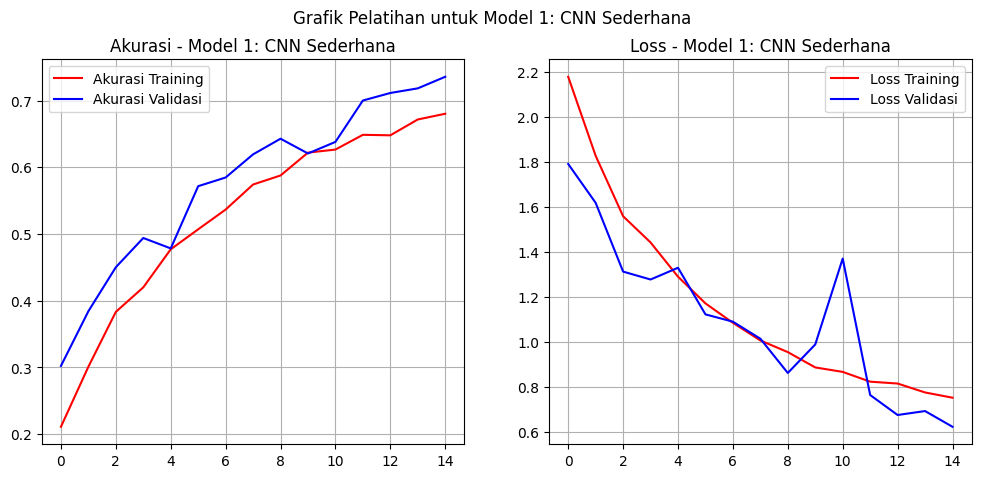

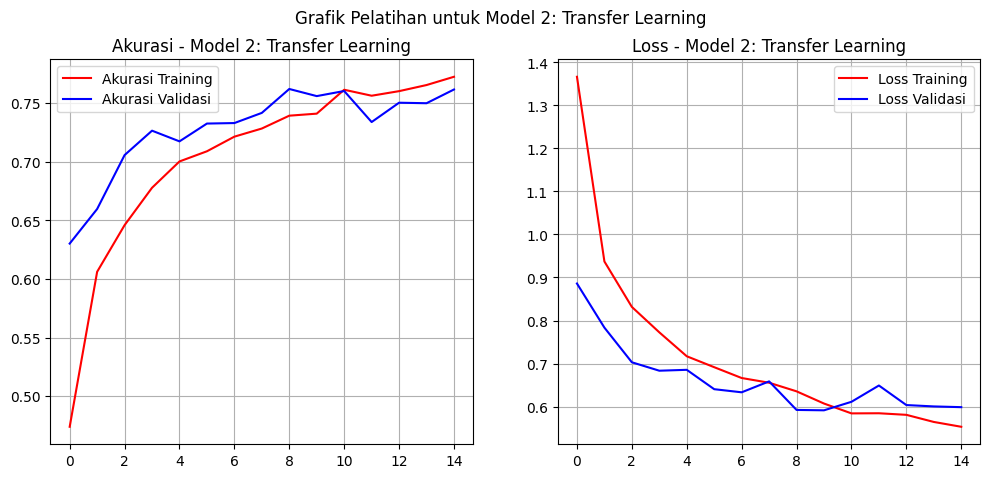

In [24]:

# --- 5. Pelatihan dan Evaluasi ---
EPOCHS = 15

print("\n--- Memulai Pelatihan Model 1: CNN Sederhana ---")
history_1 = model_1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

print("\n--- Memulai Pelatihan Model 2: Transfer Learning ---")
history_2 = model_2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

print("\n--- Evaluasi Model pada Data Validasi ---")
eval_1 = model_1.evaluate(val_dataset)
eval_2 = model_2.evaluate(val_dataset)

print(f"Hasil Model 1 (CNN Sederhana) -> Loss: {eval_1[0]:.4f}, Akurasi: {eval_1[1]*100:.2f}%")
print(f"Hasil Model 2 (Transfer Learning) -> Loss: {eval_2[0]:.4f}, Akurasi: {eval_2[1]*100:.2f}%")

# --- 6. Visualisasi Hasil ---
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'r', label='Akurasi Training')
    plt.plot(epochs_range, val_acc, 'b', label='Akurasi Validasi')
    plt.title(f'Akurasi - {title}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'r', label='Loss Training')
    plt.plot(epochs_range, val_loss, 'b', label='Loss Validasi')
    plt.title(f'Loss - {title}')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Grafik Pelatihan untuk {title}")
    plt.show()

plot_history(history_1, "Model 1: CNN Sederhana")
plot_history(history_2, "Model 2: Transfer Learning")


In [ ]:
%%sql
